In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"swethaavuku","key":"7505c7784173c304d1358c8248c3d132"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
100% 312M/312M [00:20<00:00, 17.9MB/s]
100% 312M/312M [00:20<00:00, 16.3MB/s]


In [ ]:
!unzip brain-tumor-segmentation.zip -d /content/brain_tumor_segmenation

Streaming output truncated to the last 5000 lines.
  inflating: /content/brain_tumor_segmenation/images/2013.png  
  inflating: /content/brain_tumor_segmenation/images/2014.png  
  inflating: /content/brain_tumor_segmenation/images/2015.png  
  inflating: /content/brain_tumor_segmenation/images/2016.png  
  inflating: /content/brain_tumor_segmenation/images/2017.png  
  inflating: /content/brain_tumor_segmenation/images/2018.png  
  inflating: /content/brain_tumor_segmenation/images/2019.png  
  inflating: /content/brain_tumor_segmenation/images/202.png  
  inflating: /content/brain_tumor_segmenation/images/2020.png  
  inflating: /content/brain_tumor_segmenation/images/2021.png  
  inflating: /content/brain_tumor_segmenation/images/2022.png  
  inflating: /content/brain_tumor_segmenation/images/2023.png  
  inflating: /content/brain_tumor_segmenation/images/2024.png  
  inflating: /content/brain_tumor_segmenation/images/2025.png  
  inflating: /content/brain_tumor_segmenation/images/2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install split-folders

In [ ]:
import splitfolders

In [ ]:
input_folder = '/content/drive/MyDrive/ImageSegmentation_project/Braintumor_data'
output_folder='/content/drive/MyDrive/Braintumor_data'

In [ ]:
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .1, .1), group_prefix=None)

ValueError: The provided input folder "/content/brain_tumor_segmenation" does not exists.

In [ ]:
pip install opencv-python

UNET MODEL ARCHITECTURE

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" #This suppresses TensorFlow logging except for errors.

In [ ]:
#Import all necessary packages
import numpy as np
import cv2
from glob import glob #To extract images path and mask path
from sklearn.utils import shuffle # to suffle list of images and mask
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
import os
from matplotlib import pyplot as plt


In [ ]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks.
#This gives a binary mask rather than a mask with interpolated values.


In [ ]:
#Set constants
seed=24
batch_size= 32


In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
# Seeding
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Directory for storing files
create_dir("Model")

In [ ]:
model_path = os.path.join("/content/drive/MyDrive/ImageSegmentation_project/Model", "model.keras")
csv_path = os.path.join("/content/drive/MyDrive/ImageSegmentation_project/Model", "log.csv")

## Import data into tensorflow dataset object

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rescale = 1/255.,
                         rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

mask_data_gen_args = dict(rescale = 1/255.,  #Original pixel values are 0 and 255. So rescaling to 0 to 1
                        rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again.


In [ ]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/ImageSegmentation_project/Braintumor_data/train_images",
                                                           seed=seed,
                                                           batch_size=batch_size,
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays
                                                                            #thinking class mode is binary.


Found 2451 images belonging to 1 classes.


In [ ]:
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory("/content/drive/MyDrive/ImageSegmentation_project/Braintumor_data/train_masks",
                                                         seed=seed,
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)

Found 2451 images belonging to 1 classes.


In [ ]:
valid_img_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/ImageSegmentation_project/Braintumor_data/val_images",
                                                               seed=seed,
                                                               batch_size=batch_size,
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator.flow_from_directory("/content/drive/MyDrive/ImageSegmentation_project/Braintumor_data/val_masks",
                                                               seed=seed,
                                                               batch_size=batch_size,
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


Found 306 images belonging to 1 classes.
Found 306 images belonging to 1 classes.


In [ ]:
train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

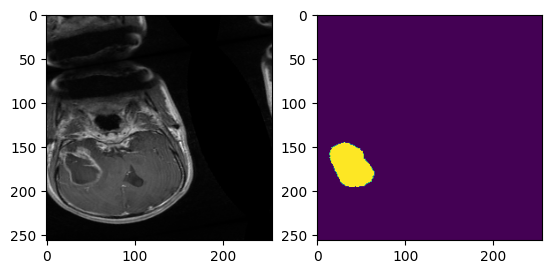

In [ ]:
# Use __next__() instead of .next()
x = image_generator.__next__()
y = mask_generator.__next__()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()


In [ ]:
input_shape = (256, 256, 3)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_54    │ (None, 256, 256, 64)   │            256 │ conv2d_57[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_54             │ (None, 256, 256, 64)   │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ activation_54[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_55    │ (None, 256, 256, 64)   │            256 │ conv2d_58[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_55             │ (None, 256, 256, 64)   │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 128, 128, 64)   │              0 │ activation_55[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_56    │ (None, 128, 128, 128)  │            512 │ conv2d_59[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_56             │ (None, 128, 128, 128)  │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ activation_56[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_57    │ (None, 128, 128, 128)  │            512 │ conv2d_60[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_57             │ (None, 128, 128, 128)  │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13     

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
 pip install focal-loss

In [ ]:
#Jaccard distance loss mimics IoU.
from keras import backend as K
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))

    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
     Ref: https://en.wikipedia.org/wiki/Jaccard_index

    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    sum_ = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [ ]:
#Dice metric can be a great metric to track accuracy of semantic segmentation.
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0

    return 2*intersection / union

In [ ]:
#loss function
from tensorflow.keras import backend as K

smooth = 1e-15
def dice_coef(masks_true, masks_pred):
    masks_true = tf.keras.layers.Flatten()(masks_true)
    masks_pred = tf.keras.layers.Flatten()(masks_pred)
    intersection = tf.reduce_sum(masks_true * masks_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(masks_true) + tf.reduce_sum(masks_pred) + smooth)

def dice_loss(masks_true, masks_pred):
    return 1.0 - dice_coef(masks_true, masks_pred)

In [ ]:
#STANDARD BINARY CROSS ENTROPY AS LOSS AND ACCURACY AS METRIC
#model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])

#JACCARD LOSS AND DICE METRIC
# model.compile(optimizer=Adam(lr = 1e-3), loss=jaccard_distance_loss,
#               metrics=[dice_metric])

In [ ]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = build_unet(input_shape)

In [ ]:
#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
from focal_loss import BinaryFocalLoss
lr = 1e-3

model.compile(optimizer=Adam(lr), loss=BinaryFocalLoss(gamma=2),
              metrics=[dice_metric])


In [ ]:
#Model
lr = 1e-4
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

In [ ]:
#callbacks
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

In [ ]:
num_train_imgs = len(os.listdir('/content/drive/MyDrive/ImageSegmentation_project/Braintumor_data/train_images/train'))

steps_per_epoch = num_train_imgs //batch_size

In [ ]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_72    │ (None, 256, 256, 64)   │            256 │ conv2d_76[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_72             │ (None, 256, 256, 64)   │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ activation_72[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_73    │ (None, 256, 256, 64)   │            256 │ conv2d_77[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_73             │ (None, 256, 256, 64)   │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 128, 128, 64)   │              0 │ activation_73[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_74    │ (None, 128, 128, 128)  │            512 │ conv2d_78[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_74             │ (None, 128, 128, 128)  │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ activation_74[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_75    │ (None, 128, 128, 128)  │            512 │ conv2d_79[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_75             │ (None, 128, 128, 128)  │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17     

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
# Assuming your generator yields something like (images, masks)
def unpack_generator(generator):
  for images, masks in generator:
    yield images, masks  # Yield the unpacked data

history = model.fit(unpack_generator(train_generator),
                    validation_data=unpack_generator(val_generator),
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=steps_per_epoch,
                    epochs=5)


Epoch 1/5
 3/76 ━━━━━━━━━━━━━━━━━━━━ 15:27 13s/step - dice_coef: 1.5026e-04 - loss: 0.9998

In [ ]:
import tensorflow as tf

In [ ]:
test_img_generator = image_data_generator.flow_from_directory("data2/test_images/",
                                                              seed=seed,
                                                              batch_size=32,
                                                              class_mode=None) #Default batch size 32, if not specified here

test_mask_generator = mask_data_generator.flow_from_directory("data2/test_masks/",
                                                              seed=seed,
                                                              batch_size=32,
                                                              color_mode = 'grayscale',   #Read masks in grayscale
                                                              class_mode=None)  #Default batch size 32, if not specified here


In [ ]:
### Testing on a few test images

a = test_img_generator.next()
b = test_mask_generator.next()
for i in range(0,5):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [ ]:
import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.6).astype(np.uint8)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()